In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from pyRothC.RothC import RothC
np.set_printoptions(precision=3,suppress=True )

## RothC 

In [49]:
"""Python version of The Rothamsted carbon model (RothC) 26.3.
    RothC is a model for the turnover of organic carbon in non-waterlogged topsoil that allows 
    for the effects of soil type, temperature, soil moisture and plant cover on the turnover process.

    Author: Misha Grol - grol81@mail.ru
"""
from typing import Union, Tuple
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.interpolate import interp1d


class RothC:
    """Class for Python version of The Rothamsted carbon model (RothC) 26.3."""

    def __init__(
        self,
        temperature: Union[list, np.ndarray],
        precip: Union[list, np.ndarray],
        evaporation: Union[list, np.ndarray],
        years: int = 500,
        ks: np.ndarray = np.array([10, 0.3, 0.66, 0.02, 0]),
        C0: np.ndarray = np.array([0, 0, 0, 0, 2.7]),
        input_carbon: Union[float, np.ndarray] = 1.7,
        farmyard_manure: Union[float, np.ndarray] = 0,
        clay: float = 23.4,
        soil_thickness: float = 25.0,
        DR: float = 1.44,  # ratio DPM/RPM
        pE: float = 0.75,
        bare: bool = False,
        solver: str = "euler",
    ):
        """Python version of The Rothamsted carbon model (RothC) 26.3.

        Args:
            temperature (Union[list, np.ndarray]): Values of monthly temperature
                                                for which the effects on decomposition rates are calculated (°C).
            precip (Union[list, np.ndarray]): Values of monthly precipitaion
                                                for which the effects on decomposition rates are calculated (mm).
            evaporation (Union[list, np.ndarray]): Values of monthly open pan evaporation or evapotranspiration (mm).
            years (int, optional): Number of years to run RothC model. Defaults to 500.
            ks (np.ndarray, optional): A vector of length 5 containing the values of the
                                    decomposition rates for the different pools.
                                    Defaults to np.array([10, 0.3, 0.66, 0.02, 0]).
            C0 (np.ndarray, optional): A numpy of length 5 containing the initial amount
                                        of carbon for the 5 pools. Defaults to np.array([0, 0, 0, 0, 2.7]).
            input_carbon (Union[float, np.ndarray], optional): A scalar or np.array
                                                                the amount of litter inputs by time. Defaults to 1.7.
            farmyard_manure (Union[float, np.ndarray], optional): A scalar or np.array object specifying the amount
                                                                 of Farm Yard Manure inputs by time. Defaults to 0.
            clay (float, optional): Percent clay in mineral soil. Defaults to 23.4.
            soil_thickness (float, optional): Soil thickness im cm. Defaults to 25.0.
            DR (float, optional): A scalar representing the ratio of decomposable plant material
                                to resistant plant material (DPM/RPM). Defaults to 1.44.
            pE (float, optional): Evaporation coefficient.
                                If open pan evaporation is used pE=0.75.
                                If Potential evaporation is used, pE=1.0.
            bare (bool, optional): Logical. Under bare soil conditions, bare=True.
                                Default is set under vegetated soil. Defaults to False.
            solver (str, optional): Solver - Not implemented yet. Defaults to "euler".

        Raises:
            ValueError: _description_
            ValueError: _description_
        """
        self.years = years
        self.t = np.linspace(1 / 12, years, num=years * 12)
        self.ks_pulls = ["DPM", "RPM", "BIO", "HUM", "IOM"]
        if len(ks) != 5:
            raise ValueError("ks must be of length = 5")
        self.ks = ks
        if len(C0) != 5:
            raise ValueError("the vector with initial conditions must be of length = 5")
        self.C0 = C0
        self.farmyard_manure = farmyard_manure
        self.input_carbon = input_carbon
        self.clay = clay
        self.DR = DR
        self.pE = pE
        self.bare = bare
        self.MONTHS_IN_YEAR = 12

        self.soil_thickness = soil_thickness
        self.solver = solver
        self._t = []
        self.xi = self._get_stress_parameters(
            temperature=np.array(temperature),
            precip=np.array(precip),
            evaporation=np.array(evaporation),
        )
        
        self.xi_func = interp1d(
            self.t, self.xi, fill_value="extrapolate"  # type: ignore
        )
        self._current_XI = []

    def _get_stress_parameters(
        self, temperature: np.ndarray, precip: np.ndarray, evaporation: np.ndarray
    ) -> np.ndarray:
        """Compute decomposition impact of Temperature and Moisture (fT * fW)

        Args:
            temperature (np.ndarray): Values of monthly temperature
                                    for which the effects on decomposition
                                    rates are calculated (°C).
            precip (np.ndarray): Values of monthly precipitaion
                                for which the effects on
                                decomposition rates are calculated (mm).
            evaporation (np.ndarray): Values of monthly open pan evaporation or evapotranspiration (mm).

        Returns:
            np.ndarray: Effects of moisture and temperature
                        on decomposition rates according to the RothC model.
        """

        stress_temp = self.fT(temperature=temperature)
        acc_TSMD, b = self.fW(
            precip=precip,
            evaporation=evaporation,
            pE=self.pE,
            bare=self.bare,
            clay=self.clay,
            soil_thickness=self.soil_thickness,
        )
        self._stress_temp = stress_temp
        self._b = b
        xi = stress_temp * b
        xi = np.tile(xi, self.years)
        return xi

    def fT(self, temperature: np.ndarray) -> list:
        """Compute Temperature factor

        Args:
            temperature (np.ndarray): monthly mean temperature

        Returns:
            list: monthly temperature factor
        """
        stress_coef = []
        for x in temperature:
            if x < -18.3:
                stress_coef.append(np.nan)
            else:
                stress_coef.append(47.9 / (1 + np.exp(106 / (x + 18.3))))
        return stress_coef

    def fW(
        self,
        precip: np.ndarray,
        evaporation: np.ndarray,
        soil_thickness: float,
        pE: float = 0.75,
        clay: float = 20.0,
        bare: Union[bool, np.ndarray] = False,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Compute Soil moisture factor

        Args:
            precip (np.ndarray): Values of monthly precipitaion
                                for which the effects on
                                decomposition rates are calculated (mm).
            evaporation (np.ndarray): Values of monthly open pan evaporation or evapotranspiration (mm).
            soil_thickness (float): Soil thickness in cm. Default for Rothamsted is 23 cm.
            pE (float, optional): Evaporation coefficient.
                                If open pan evaporation is used pE=0.75.
                                If Potential evaporation is used, pE=1.0.. Defaults to 0.75.
            clay (float, optional): Percent clay in mineral soil. Defaults to 23.4.
                                 Defaults to 20.0.
            bare (bool, optional): Logical. Under bare soil conditions, bare=True.
                                Default is set under vegetated soil.
                                Defaults to False.

        Raises:
            ValueError: Precip and evaporation have different shape

        Returns:
            Tuple[np.ndarray, np.ndarray]: _description_
        """
        # compute maximum soil moisture deficit
        if precip.shape != evaporation.shape:
            raise ValueError("Precip and evaporation have different shape")
        
        max_smd = -(20.0 + 1.3 * clay - 0.01 * clay**2) * (
            soil_thickness / 23
        )  # TO-DO Verify this soil_thik / 23

        max_smd = np.full(self.MONTHS_IN_YEAR, max_smd)
        mask = bare.astype(bool)
        max_smd[mask] /= 1.8
        M = precip - evaporation * pE
        acc_TSMD = np.zeros(shape=(len(M)))
        if M[0] > 0:
            acc_TSMD[0] = 0
        else:
            acc_TSMD[0] = M[0]
        for i in range(1, len(M)):
            if acc_TSMD[i - 1] + M[i] < 0:
                acc_TSMD[i] = acc_TSMD[i - 1] + M[i]
            else:
                acc_TSMD[i] = 0
            if acc_TSMD[i] <= max_smd[i]:
                acc_TSMD[i] = max_smd[i]
        b = np.zeros(shape=acc_TSMD.shape)
        mask = acc_TSMD > 0.444 * max_smd
        b = 0.2 + 0.8 * ((max_smd - acc_TSMD) / (max_smd - 0.444 * max_smd))
        b[mask] = 1
        return acc_TSMD, b

    def get_input_flux(
        self, input_carbon: float, farmyard_manure: float = 0, DR: float = 1.44
    ) -> np.ndarray:
        """Get amount of litter inputs

        Args:
            input_carbon (float): A scalar or np.array
                                the amount of litter inputs by time. Defaults to 1.7.
            farmyard_manure (float, optional): A scalar or np.array object specifying the amount
                                                of Farm Yard Manure inputs by time.
                                                Defaults to 0.
            DR (float, optional): A scalar representing the ratio of decomposable plant material
                                to resistant plant material (DPM/RPM). Defaults to 1.44.

        Returns:
            np.ndarray: input_DPM, input_RPM, input_BIO, input_HUM, input_IOM
        """
        gamma = DR / (1 + DR)
        input_DPM = input_carbon * gamma + (farmyard_manure * 0.49)
        input_RPM = input_carbon * (1 - gamma) + (farmyard_manure * 0.49)
        input_BIO = 0
        input_HUM = farmyard_manure * 0.02
        input_IOM = 0
        return np.array([input_DPM, input_RPM, input_BIO, input_HUM, input_IOM])

    def dCdt(self, C, t):
        self._t.append(t)
        ks = self.ks
        x = 1.67 * (1.85 + 1.60 * np.exp(-0.0786 * self.clay))
        B = 0.46 / (x + 1)
        H = 0.54 / (x + 1)
        ai3 = B * ks
        ai4 = H * ks
        A = np.diag(-ks)
        A[2] = A[2] + ai3
        A[3] = A[3] + ai4
        in_flux = self.get_input_flux(
            self.input_carbon, self.farmyard_manure, self.DR  # type: ignore
        )  # TO-DO: add not only scalar
        xi_f = self.xi_func(t)
        self._current_XI.append(xi_f)
        C_next = in_flux + (A * xi_f).dot(C)
        return C_next

    def compute(self):
        y1 = odeint(self.dCdt, self.C0, t=self.t, rtol=0.01, atol=0.01)
        return pd.DataFrame(y1, columns=self.ks_pulls)


temperature = np.array(
    [-0.4, 0.3, 4.2, 8.3, 13.0, 15.9, 18.0, 17.5, 13.4, 8.7, 3.9, 0.6]
)
precipitation = np.array([49, 39, 44, 41, 61, 58, 71, 58, 51, 48, 50, 58])
evaporation = np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31, 14, 10])
inert_organic_matter = 0.049 * 69.7**1.139

rothc = RothC(
    temperature=temperature,
    precip=precipitation,
    evaporation=evaporation,
    years=2,  # Test the results for 2 years for simplicity.
    clay=48,
    input_carbon=2.7,
    pE=1.0,
    C0=np.array([0, 0, 0, 0, inert_organic_matter]),
    bare=np.array([0,0,0,1,1,1,1,1,1,0,0,0])
)
dataframe = rothc.compute()


In [2]:
stress_temp = rothc.fT(temperature=temperature)
acc_TSMD, b = rothc.fW(
    precip=precipitation,
    evaporation=evaporation,
    pE=rothc.pE,
    bare=rothc.bare,
    clay=rothc.clay,
    soil_thickness=rothc.soil_thickness,
)
rothc._stress_temp = stress_temp
rothc._b = b
xi = stress_temp * b
xi = np.tile(xi, rothc.years)

In [31]:
max_smb = -64.52173913043478 
bare = np.array([0,0,0,1,1,1,1,1,1,0,0,0])
mask = bare.astype(bool)
max_smb = np.array([max_smb] * len(bare))
max_smb[mask] = max_smb[mask]/1.8
max_smb

array([-64.522, -64.522, -64.522, -35.845, -35.845, -35.845, -35.845,
       -35.845, -35.845, -64.522, -64.522, -64.522])

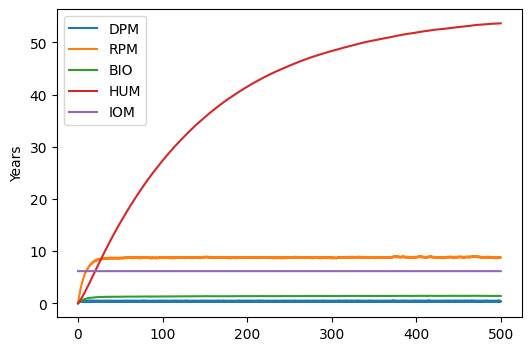

In [50]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
input_carbon=2.7   #Annual C inputs to soil in Mg/ha/yr

IOM=0.049*SOC**(1.139) # Falloon et al. (1998)


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=input_carbon,
             pE=1.0,
             C0=np.array([0, 0, 0, 0, IOM]), 
             bare=np.array([0,0,0,1,1,1,1,1,1,0,0,0]))

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

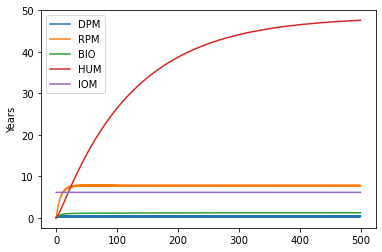

In [18]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
input_carbon=2.7   #Annual C inputs to soil in Mg/ha/yr

IOM=0.049*SOC**(1.139) # Falloon et al. (1998)


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=input_carbon,
             pE=1.0,
             C0=np.array([0, 0, 0, 0, IOM]))

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## Pedotranser functions for initial soil conditions

----

Paper: [Weihermueller et al. (2013)](https://bsssjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/ejss.12036?casa_token=_IP4YS2QpN0AAAAA:GTB174qCuWQlDN_5IfvM_j43agtnlIcn4C2i4uG5tsKDZqnksafuCaOywdCfUh_YmI-7xljoCElLkwGqKA)

In [22]:
RPMptf=(0.184*SOC + 0.1555)*(clay + 1.275)**(-0.1158)
HUMptf=(0.7148*SOC + 0.5069)*(clay + 0.3421)**(0.0184)
BIOptf=(0.014*SOC + 0.0075)*(clay + 8.8473)**(0.0567)

DPMptf=SOC-IOM-RPMptf-HUMptf-BIOptf

C0=np.array([DPMptf, RPMptf, BIOptf, HUMptf, IOM])

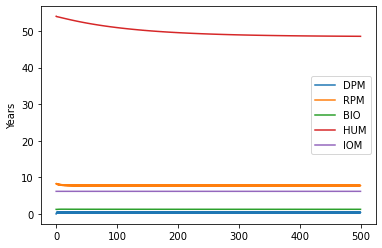

In [23]:
rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=input_carbon,
             pE=1.0,
             C0=C0)

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## End

In [16]:
import pandas as pd

df = pd.read_csv('~/Downloads/data.csv')


In [17]:
df

,0,Point,LAT,LON,Moisture_perc_10,Moisture_perc_30,Moisture_perc_80,mean_yeild_c_per_ha,pen_resist_10,pen_resist_30,pen_resist_80,temp_10,temp_30,temp_80
0,K1,1,5751430.197,417003.844,18.93,24.56,17.82,681.7,193.15,210.35,288.85,22.50,18.90,16.30
1,K2,2,5751336.254,416995.506,23.30,24.10,19.49,578.3,106.28,181.38,272.00,20.20,18.30,16.20
2,K3,3,5751240.420,416980.347,23.57,22.89,19.07,626.7,143.37,143.06,292.80,20.60,19.70,17.20
3,K4,4,5751141.626,416976.802,21.36,21.98,17.64,666.7,183.06,325.34,336.20,18.80,17.60,16.00
4,K5,5,5751044.174,416969.528,21.43,20.35,11.15,536.7,119.60,171.37,326.65,20.20,18.90,16.80
5,K6,6,5750943.559,416966.347,20.99,20.13,21.28,731.7,284.85,318.51,385.45,19.30,19.20,15.90
6,K7,7,5751427.601,417098.874,20.23,23.87,21.84,458.3,110.14,200.30,268.10,20.40,18.40,16.00
7,K8,8,5751327.304,417087.221,23.72,22.52,16.67,541.7,99.91,195.36,269.10,20.00,18.10,15.80
8,K9,9,5751226.513,417067.289,20.23,21.64,22.66,796.7,92.20,213.64,324.10,20.10,18.10,15.40
9,K10,10,5751129.808,417048.901,25.35,25.84,18.26,608.3,273.04,294.69,380.90,19.10,17.90,15.70
